# Exploring and undertanding documental databases with topic models

Version 1.0

Date: Nov 23, 2017

Authors: 

   * Jerónimo Arenas-García (jeronimo.arenas@uc3m.es)
   * Jesús Cid-Sueiro (jcid@tsc.uc3m.es)

In [1]:
# Common imports 

%matplotlib inline
import matplotlib.pyplot as plt
import pylab

import numpy as np
# import pandas as pd
# import os
from os.path import isfile, join
# import scipy.io as sio
# import scipy
import zipfile as zp
# import shutil
# import difflib

import gensim

## 1. Corpus acquisition

In this block we will work with collections of text documents. The objectives will be:

   * Find the most important topics in the collection and assign documents to topics
   * Analyze the structure of the collection by means of graph analysis
   
We will work with a collection of research projects funded by the US National Science Foundation, that you can find under the `./data` directory. These files are publicly available from the NSF website.

### 1.1. Exploring file structure

NSF project information is provided in XML files. Projects are yearly grouped in `.zip` files, and each project is saved in a different XML file. To explore the structure of such files, we will use the file `160057.xml`. Parsing XML files in python is rather easy using the `ElementTree` module. 

#### 1.1.1. File format

To start with, you can have a look at the contents of the example file. We are interested on the following information of each project:

   * Project identifier
   * Project Title
   * Project Abstract
   * Budget
   * Starting Year (we will ignore project duration)
   * Institution (name, zipcode, and state)

In [2]:
xmlfile = '../data/1600057.xml'

with open(xmlfile,'r') as fin:
    print(fin.read())

<?xml version="1.0" encoding="UTF-8"?>
<rootTag>
<Award>
<AwardTitle>Novel States in Spin-Orbit-Coupled and Correlated Materials</AwardTitle>
<AwardEffectiveDate>08/01/2016</AwardEffectiveDate>
<AwardExpirationDate>12/31/2016</AwardExpirationDate>
<AwardAmount>306810</AwardAmount>
<AwardInstrument>
<Value>Continuing grant</Value>
</AwardInstrument>
<Organization>
<Code>03070000</Code>
<Directorate>
<LongName>Direct For Mathematical &amp; Physical Scien</LongName>
</Directorate>
<Division>
<LongName>Division Of Materials Research</LongName>
</Division>
</Organization>
<ProgramOfficer>
<SignBlockName>Tomasz Durakiewicz</SignBlockName>
</ProgramOfficer>
<AbstractNarration>Non-technical Abstract:&lt;br/&gt;Modern condensed matter physics research has produced novel materials with fundamental properties that underpin a remarkable number of cutting-edge technologies. It is now generally accepted that novel materials are necessary for critical advances in technologies and whoever discovers no

#### 1.1.2. Parsing XML

XML is an inherently hierarchical data format, and the most natural way to represent it is with a tree. The `ElementTree` module has two classes for this purpose:

   * `ElementTree` represents the whole XML document as a tree
   * `Element` represents a single node in this tree

We can import XML data by reading an XML file:

In [3]:
import xml.etree.ElementTree as ET
root = ET.fromstring(open(xmlfile,'r').read())

The code below implements a function that parses the XML files and provides as its output a dictionary with fields:

    project_code      (string)
    title             (string)
    abstract          (string)
    budget            (float)
    year              (string)
    institution       (tuple with elements: name, zipcode, and statecode)


In [4]:
def parse_xmlproject(xml_string):
    """This function processess the specified XML field,
    and outputs a dictionary with the desired project information
    
    :xml_string: String with XML content
    :Returns: Dictionary with indicated files
    """
    
    root = ET.fromstring(xml_string)
    dictio = {}
    
    for child in root[0]:
        if child.tag.lower() == 'awardtitle':
            dictio['title'] = child.text
        elif child.tag.lower() == 'awardeffectivedate':
            dictio['year'] = str(child.text[-4:])
        elif child.tag.lower() == 'awardamount':
            dictio['budget'] = float(child.text)
        elif child.tag.lower() == 'abstractnarration':
            dictio['abstract'] = child.text
        elif child.tag.lower() == 'awardid':
            dictio['project_code'] = child.text
        elif child.tag.lower() == 'institution':
            #For the institution we have to access the children elements
            #and search for the name, zipcode, and statecode only
            name = ''
            zipcode = ''
            statecode = ''
            for child2 in child:
                if child2.tag.lower() == 'name':
                    name = child2.text
                elif child2.tag.lower() == 'zipcode':
                    zipcode = child2.text
                elif child2.tag.lower() == 'statecode':
                    statecode = child2.text
            dictio['institution'] = (name, zipcode, statecode)
    
    return dictio
    
parse_xmlproject(open(xmlfile,'r').read())

{'title': 'Novel States in Spin-Orbit-Coupled and Correlated Materials',
 'year': '2016',
 'budget': 306810.0,
 'abstract': 'Non-technical Abstract:<br/>Modern condensed matter physics research has produced novel materials with fundamental properties that underpin a remarkable number of cutting-edge technologies. It is now generally accepted that novel materials are necessary for critical advances in technologies and whoever discovers novel materials generally controls the science and technology of the future. Transition metal oxides have attracted enormous interest within both the basic and applied science communities.  However, for many decades, the overwhelming balance of effort was focused on the 3d-elements (such as iron, copper, etc.) and their compounds; the heavier 4d- and 5d-elements (such as ruthenium, iridium, etc., which constitute two thirds of the d-elements listed in the Periodic Table) and their compounds have been largely ignored until recently. The principal investiga

### 1.2. Building the dataset

Now, we will use the function you just implemented, to create a database that we will use throughout this module.

For simplicity, and given that the dataset is not too large, we will keep all projects in the RAM. The dataset will consist of a list containing the dictionaries associated to each of the considered projects in a time interval.

In [5]:
# Construct an iterator (or a list) for the years you want to work with
years = [2015, 2016]
datafiles_path = '../data/'
NSF_data = []

for year in years:
    
    zpobj = zp.ZipFile(join(datafiles_path, str(year)+'.zip'))
    for fileinzip in zpobj.namelist():
        if fileinzip.endswith('xml'):
            
            #Some files seem to be incorrectly parsed
            try:
                project_dictio = parse_xmlproject(zpobj.read(fileinzip))
                if project_dictio['abstract']:
                    NSF_data.append(project_dictio)
            except:
                pass

We will extract some characteristics of the constructed dataset:

In [6]:
print('Number of projects in dataset:', len(NSF_data))

# Budget
budget_data = list(map(lambda x: x['budget'], NSF_data))
print('Average budget of projects in dataset:', np.mean(budget_data))

# Institutions
insti_data = list(map(lambda x: x['institution'], NSF_data))
print('Number of unique institutions in dataset:', len(set(insti_data)))

# Counts per year
counts = dict()
for project in NSF_data:
    counts[project['year']] = counts.get(project['year'],0) + 1

print('Breakdown of projects by starting year:')
for el in counts:
    print(el, ':', counts[el])

Number of projects in dataset: 24342
Average budget of projects in dataset: 342411.6244351327
Number of unique institutions in dataset: 2786
Breakdown of projects by starting year:
2015 : 9039
2014 : 344
2016 : 12401
2017 : 2554
2013 : 1
2018 : 3


For the rest of this notebook, we will work with the abstracts only. The list of all abstract will be the corpus we will work with.

In [7]:
corpus_raw = list(map(lambda x: x['abstract'], NSF_data))

abstractlen_data = list(map(lambda x: len(x), corpus_raw))
print('Average length of projects abstracts (in characters):', np.mean(abstractlen_data))

Average length of projects abstracts (in characters): 2605.887807082409


## 2. Corpus Processing

Topic modelling algorithms process vectorized data. In order to apply them, we need to transform the raw text input data into a vector representation. To do so, we will remove irrelevant information from the text data and preserve as much relevant information as possible to capture the semantic content in the document collection.

Thus, we will proceed with the following steps:

1. Tokenization
2. Homogeneization, which includes:
    1. Removing capitalization.
    2. Removing non alphanumeric tokens (e.g. punktuation signs)
    3. Stemming/Lemmatization.
3. Cleaning
4. Vectorization

For the first steps, we will use some of the powerful methods available from the [Natural Language Toolkit](http://www.nltk.org). In order to use the `word_tokenize` method from nltk, you might need to get the appropriate libraries using `nltk.download()`. You must select option "d) Download", and identifier "punkt"

In [8]:
from nltk import download
# You should comment this code fragment if the package is already available.
# download('punkt')
# download('stopwords')

### 2.1. Corpus Processing

We will create a list that contains just the abstracts in the dataset. As the order of the elements in a list is fixed, it will be later straightforward to match the processed abstracts to metadata associated to their corresponding projects.

**Exercise 1**: Generate a corpus of processed documents. For each document in `corpus_raw` complete the following steps:
1. Tokenize.
2. Remove capitalization and non-alphanumeric tokens.
3. Lemmatize
4. Remove the stopwords using the NLTK stopwords list.


In [9]:
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

# Maybe you can try the stemmer too.
# stemmer = SnowballStemmer('english')
wnl = WordNetLemmatizer()

stopwords_en = stopwords.words('english')

# Initialize ouput corpus
corpus_clean = []

ndocs = len(corpus_raw)
for n, text in enumerate(corpus_raw):
    if not n%100:
        print('\rTokenizing document', n, 'out of', ndocs, end='', flush=True)

    # Tokenize each text entry. 
    # tokens = <FILL IN>
    tokens = word_tokenize(text)
    # tokens_filtered = <FILL IN>
    tokens_filtered = [el.lower() for el in tokens if el.isalnum()]
    # tokens_lemmatized = <FILL IN>
    tokens_lemmatized = [wnl.lemmatize(el) for el in tokens_filtered]
    # tokens_clean = <FILL IN>
    tokens_clean = [token for token in tokens_lemmatized if token not in stopwords_en]    
    
    # Add the new token list as a new element to corpus_clean (that will be a list of lists)
    # corpus_clean.<FILL IN>
    corpus_clean.append(tokens_clean)

print('\n\n The corpus has been tokenized. Check the result for the first abstract:')
print(corpus_raw[0])
print(corpus_clean[0])

Tokenizing document 24300 out of 24342

 The corpus has been tokenized. Check the result for the first abstract:
The past few years have seen unprecedented growth in mobile data consumption. Powered in large part by the rapid adoption of smart phones and tablets, the growth in wireless data creates phenomenal challenges for the wireless industry, which has been unable to meet the demand for rich mobile content through cellular networks. This has led to the investigation of solutions by network operators that aim to utilize WiFi radios present in these mobile devices to deliver content without using the cellular radio links, also known as content-offloading.  Industry-led approaches aim to utilize WiFi infrastructure in the form of access points to offload this content, but these have various deployment issues. Research has lately focused on the potential of proximity-based peer content sharing, since proximity enables low-power, high speed data exchanges which in turn allows mobile dev

### 2.4. Vectorization

Up to this point, we have transformed the raw text collection in a list of documents, where each documen is a collection of the words that are most relevant for semantic analysis. Now, we need to convert these data (a list of token lists) into a numerical representation (a list of vectors, or a matrix). To do so, we will start using the tools provided by the `gensim` library. 

As a first step, we create a dictionary containing all tokens in our text corpus, and assigning an integer identifier to each one of them.

In [10]:
# Create dictionary of tokens
D = gensim.corpora.Dictionary(corpus_clean)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 60693 terms
First terms in the dictionary:
0 : access
1 : across
2 : adoption
3 : aim
4 : allows
5 : also
6 : amenable
7 : another
8 : approach
9 : area


We can also filter out terms that appear in too few or too many of the documents in the dataset:

In [11]:
no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .75 #Maximum proportion of documents in which a term can appear to be kept in the dictionary
D.filter_extremes(no_below=no_below, no_above=no_above, keep_n=25000)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 20046 terms
First terms in the dictionary:
0 : access
1 : across
2 : adoption
3 : aim
4 : allows
5 : also
6 : amenable
7 : another
8 : approach
9 : area


In the second step, let us create a numerical version of our corpus using the `doc2bow` method. In general, `D.doc2bow(token_list)` transforms any list of tokens into a list of tuples `(token_id, n)`, one per each token in `token_list`, where `token_id` is the token identifier (according to dictionary `D`) and `n` is the number of occurrences of such token in `token_list`. 

**Exercise 2**: Apply the `doc2bow` method from gensim dictionary `D`, to all tokens in every document in `clean_abstracts`. The result must be a new list named `corpus_bow` where each element is a list of tuples `(token_id, number_of_occurrences)`.

In [12]:
# corpus_bow = <FILL IN>
corpus_bow = [D.doc2bow(doc) for doc in corpus_clean]

At this point, it is good to make sure to understand what has happened. In `clean_abstracts` we had a list of token lists. With it, we have constructed a Dictionary, `D`, which assigns an integer identifier to each token in the corpus.
After that, we have transformed each article (in `clean_abstracts`) in a list tuples `(id, n)`. 

In [13]:
print('Original document (after cleaning):')
print(corpus_clean[0])
print('Sparse vector representation (first 10 components):')
print(corpus_bow[0][:10])
print('Word counts for the first project (first 10 components):')
print(list(map(lambda x: (D[x[0]], x[1]), corpus_bow[0][:10])))

Original document (after cleaning):
['past', 'year', 'seen', 'unprecedented', 'growth', 'mobile', 'data', 'consumption', 'powered', 'large', 'part', 'rapid', 'adoption', 'smart', 'phone', 'tablet', 'growth', 'wireless', 'data', 'creates', 'phenomenal', 'challenge', 'wireless', 'industry', 'ha', 'unable', 'meet', 'demand', 'rich', 'mobile', 'content', 'cellular', 'network', 'ha', 'led', 'investigation', 'solution', 'network', 'operator', 'aim', 'utilize', 'wifi', 'radio', 'present', 'mobile', 'device', 'deliver', 'content', 'without', 'using', 'cellular', 'radio', 'link', 'also', 'known', 'approach', 'aim', 'utilize', 'wifi', 'infrastructure', 'form', 'access', 'point', 'offload', 'content', 'various', 'deployment', 'issue', 'research', 'ha', 'lately', 'focused', 'potential', 'peer', 'content', 'sharing', 'since', 'proximity', 'enables', 'high', 'speed', 'data', 'exchange', 'turn', 'allows', 'mobile', 'device', 'proactively', 'share', 'data', 'one', 'another', 'study', 'using', 'situati

Note that we can interpret each element of corpus_bow as a `sparse_vector`. For example, a list of tuples 

    [(0, 1), (3, 3), (5,2)] 

for a dictionary of 10 elements can be represented as a vector, where any tuple `(id, n)` states that position `id` must take value `n`. The rest of positions must be zero.

    [1, 0, 0, 3, 0, 2, 0, 0, 0, 0]

These sparse vectors will be the inputs to the topic modeling algorithms.

As a summary, the following variables will be relevant for the next chapters:
   * `D`: A gensim dictionary. Term strings can be accessed using the numeric identifiers. For instance, `D[0]` contains the string corresponding to the first position in the BoW representation.
   * `corpus_bow`: BoW corpus. A list containing an entry per project in the dataset, and consisting of the (sparse) BoW representation for the abstract of that project.
   * `NSF_data`: A list containing an entry per project in the dataset, and consisting of metadata for the projects in the dataset
   
The way we have constructed the `corpus_bow` variable guarantees that the order is preserved, so that the projects are listed in the same order in the lists `corpus_bow` and `NSF_data`.

Before starting with the semantic analyisis, it is interesting to observe the token distribution for the given corpus.

In [14]:
# SORTED TOKEN FREQUENCIES (I):
# Create a "flat" corpus with all tuples in a single list
corpus_bow_flat = [item for sublist in corpus_bow for item in sublist]

# Initialize a numpy array that we will use to count tokens.
# token_count[n] should store the number of ocurrences of the n-th token, D[n]
token_count = np.zeros(n_tokens)

# Count the number of occurrences of each token.
for x in corpus_bow_flat:
    # Update the proper element in token_count
    # scode: <FILL IN>
    token_count[x[0]] += x[1]

# Sort by decreasing number of occurences
ids_sorted = np.argsort(- token_count)
tf_sorted = token_count[ids_sorted]

`ids_sorted` is a list of all token ids, sorted by decreasing number of occurrences in the whole corpus. For instance, the most frequent term is 

In [15]:
print(D[ids_sorted[0]])

student


which appears

In [16]:
print("{0} times in the whole corpus".format(tf_sorted[0]))

42100.0 times in the whole corpus


In the following we plot the most frequent terms in the corpus.

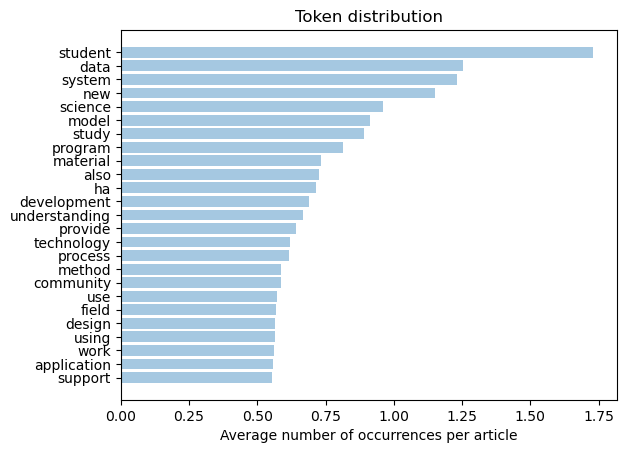

In [17]:
# SORTED TOKEN FREQUENCIES (II):
plt.rcdefaults()

# Example data
n_art = len(NSF_data)
n_bins = 25
hot_tokens = [D[i] for i in ids_sorted[n_bins-1::-1]]
y_pos = np.arange(len(hot_tokens))
z = tf_sorted[n_bins-1::-1]/n_art

plt.figure()
plt.barh(y_pos, z, align='center', alpha=0.4)
plt.yticks(y_pos, hot_tokens)
plt.xlabel('Average number of occurrences per article')
plt.title('Token distribution')
plt.show()

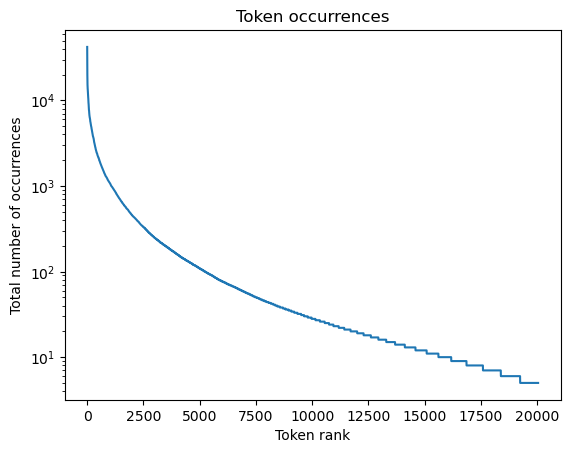

In [18]:
# SORTED TOKEN FREQUENCIES:

# Example data
plt.figure()
plt.semilogy(tf_sorted)
plt.ylabel('Total number of occurrences')
plt.xlabel('Token rank')
plt.title('Token occurrences')
plt.show()

In [19]:
# cold_tokens = <FILL IN>
cold_tokens = [D[i] for i in ids_sorted if tf_sorted[i]==1]

print("There are {0} cold tokens, which represent {1}% of the total number of tokens in the dictionary".format(
    len(cold_tokens), float(len(cold_tokens))/n_tokens*100))

There are 0 cold tokens, which represent 0.0% of the total number of tokens in the dictionary


### 2.5. Dictionary properties

As a final comment, note that gensim dictionaries contain a method `dfs` to compute the word counts automatically. In the code below we build a list `all_counts` that contains tuples (terms, document_counts). 

In [20]:
all_counts = [(D[el], D.dfs[el]) for el in D.dfs]
all_counts = sorted(all_counts, key=lambda x: x[1])

## 3. Topic Modeling

There are several implementations of the LDA topic model in python:

* Python library `lda`.
* Gensim module: `gensim.models.ldamodel.LdaModel`
* Sci-kit Learn module: `sklearn.decomposition`

In the following sections we explore the use of `gensim`

### 3.1. Training a topic model using Gensim LDA

Since we already have computed the dictionary and documents BoW representation using Gensim, computing the topic model is straightforward using the `LdaModel()` function. Please, refer to Gensim API documentation for more information on the different parameters accepted by the function:

**Exercise 3**: Create an LDA model with the 50 topics using `corpus_bow` and the dictionary, `D`.

In [21]:
num_topics = 50

# This might take some time...
# ldag = gensim.models.ldamodel.LdaModel(<FILL IN>)
ldag = gensim.models.ldamodel.LdaModel(corpus=corpus_bow, id2word=D, num_topics=num_topics)


### 3.2. LDA model visualization

Gensim provides a basic visualization of the obtained topics:

In [22]:
ldag.print_topics(num_topics=-1, num_words=10)

[(0,
  '0.013*"change" + 0.011*"forest" + 0.009*"data" + 0.009*"climate" + 0.008*"ecosystem" + 0.008*"record" + 0.007*"year" + 0.007*"past" + 0.007*"region" + 0.006*"provide"'),
 (1,
  '0.032*"social" + 0.013*"policy" + 0.009*"study" + 0.008*"value" + 0.007*"citizen" + 0.007*"organization" + 0.007*"public" + 0.007*"theory" + 0.006*"economic" + 0.006*"market"'),
 (2,
  '0.032*"ocean" + 0.025*"marine" + 0.017*"organic" + 0.013*"carbon" + 0.010*"cycling" + 0.009*"nutrient" + 0.008*"process" + 0.007*"ecosystem" + 0.007*"dissolved" + 0.007*"student"'),
 (3,
  '0.022*"system" + 0.012*"network" + 0.011*"software" + 0.010*"user" + 0.009*"design" + 0.007*"patient" + 0.007*"service" + 0.006*"security" + 0.006*"device" + 0.006*"hardware"'),
 (4,
  '0.012*"mathematical" + 0.009*"study" + 0.009*"sequence" + 0.008*"pi" + 0.008*"cluster" + 0.007*"knot" + 0.007*"mutation" + 0.007*"student" + 0.006*"work" + 0.006*"mathematics"'),
 (5,
  '0.015*"product" + 0.014*"technology" + 0.013*"manufacturing" + 0.

A more useful visualization is provided by the python LDA visualization library, pyLDAvis.

Before executing the next code fragment you might need to install pyLDAvis:

    >> pip install (--user) pyLDAvis

In [26]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

vis_data = gensimvis.prepare(ldag, corpus_bow, D)
pyLDAvis.display(vis_data)

### 3.3. Gensim utility functions

In addition to visualization purposes, topic models are useful to obtain a semantic representation of documents that can later be used with some other purpose:

   * In document classification problems
   * In content-based recommendations systems

Essentially, the idea is that the topic model provides a (semantic) vector representation of documents, and use probability divergences to measure document similarity. The following functions of the `LdaModel` class will be useful in this context:

   * `get_topic_terms(topic_id)`: Gets vector of the probability distribution among words for the indicated topic
   * `get_document_topics(bow_vector)`: Gets (sparse) vector with the probability distribution among topics for the provided document
   

**Exercise 4**: Show the probability distribution over words for topic 0.

In [28]:
# <SOL>
print(ldag.get_topic_terms(topicid=0))
# </SOL>

[(848, 0.01258766), (5024, 0.010817766), (27, 0.009006309), (2605, 0.008521202), (3078, 0.008248682), (2203, 0.008005706), (130, 0.0071066013), (72, 0.0066673784), (1659, 0.006504727), (86, 0.006121381)]


**Exercise 5**: Show the probability distribution over topics for document 0.

In [ ]:
print(ldag.get_document_topics(corpus_bow[0]))

An alternative to the use of the `get_document_topics()` function is to directly transform a dataset using the `ldag` object as follows. You can apply this transformation to several documents at once, but then the result is an iterator from which you can build the corresponding list if necessary

In [ ]:
print(ldag[corpus_bow[0]])

print('When applied to a dataset it will provide an iterator')
print(ldag[corpus_bow[:3]])

print('We can rebuild the list from the iterator with a one liner')
print([el for el in ldag[corpus_bow[:3]]])

Finally, Gensim provides some useful functions to convert between formats, and to simplify interaction with numpy and scipy. The following code fragment converts a corpus in sparse format to a full numpy matrix

In [ ]:
reduced_corpus = [el for el in ldag[corpus_bow[:3]]]
reduced_corpus = gensim.matutils.corpus2dense(reduced_corpus, num_topics).T
print(reduced_corpus)

**Exercise 6**: Build a function that returns the most relevant projects for a given topic

In [ ]:
def most_relevant_projects(ldag, topicid, corpus_bow, nprojects=10):
    """This function returns the most relevant projects in corpus_bow
    
    : ldag: The trained topic model object provided by gensim
    : topicid: The topic for which we want to find the most relevant documents
    : corpus_bow: The BoW representation of documents in Gensim format
    : nprojects: Number of most relevant projects to identify
    
    : Returns: A list with the identifiers of the most relevant projects
    """

    print('Computing most relevant projects for Topic', topicid)
    print('Topic composition is:')
    print(ldag.show_topic(topicid))
    
    #<SOL>
    document_topic = [el for el in ldag[corpus_bow]]
    document_topic = gensim.matutils.corpus2dense(document_topic, ldag.num_topics).T
    return np.argsort(document_topic[:,topicid])[::-1][:nprojects].tolist()
    #</SOL>
    
#To test the function we will find the most relevant projects for a subset of the NSF dataset
project_id = most_relevant_projects(ldag, 17, corpus_bow[:10000])

#Print titles of selected projects
for idproject in project_id:
    print(NSF_data[idproject]['title'])

**Exercise 7**: Build a function that computes the semantic distance between two documents. For this, you can use the functions (or code fragments) provided in the library `dist_utils.py`.

In [ ]:
def pairwase_dist(doc1, doc2):
    """This function returns the Jensen-Shannon
    distance between the corresponding vectors of the documents
    
    : doc1: Semantic representation for the doc1 (a vector of length ntopics)
    : doc2: Semantic representation for the doc2 (a vector of length ntopics)

    : Returns: The JS distance between doc1 and doc2 (a number)
    """
    #<SOL>
    #</SOL>

**Exercise 8**: Explore the influence of the concentration parameters, $alpha$ and $eta$. In particular observe how do topic and document distributions change as these parameters increase.

**Exercise 9**: Note that we have not used the terms in the article titles, though the can be expected to contain relevant words for the topic modeling. Include the title words in the analyisis. In order to give them a special relevante, insert them in the corpus several times, so as to make their words more significant.



## 4. Saving data.

The following function creates the Node CSV file that could be usefult for further processing. In particular, the output files could be used to visualize the document corpus as a graph using a visualization software like Gephi.

In [ ]:
#print(NSF_data[0].keys())
#print(NSF_data[0]['institution'])

def strNone(str_to_convert):
    if str_to_convert is None:
        return ''
    else:
        return str_to_convert

with open('NSF_nodes.csv','w') as fout:
    fout.write('Id;Title;Year;Budget;UnivName;UnivZIP;State\n')
    for project in NSF_data:
        fout.write(project['project_code']+';'+project['title']+';')
        fout.write(project['year']+';'+str(project['budget'])+';')
        fout.write(project['institution'][0]+';')
        fout.write(strNone(project['institution'][1])+';')
        fout.write(strNone(project['institution'][2])+'\n')